<h2>Imports</h2>

In [9]:
import math
import random
import os
from common.multiprocessing_env import SubprocVecEnv
from ppo import *
from ensembles import *
import datetime
import fnmatch

import gym
import my_envs
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

np.random.seed(0)
torch.manual_seed(2)

%matplotlib inline

# Load baseline policies
Load trained baseline policies on individually modified environments for testing on multi-modified environment
### Environments:

#### InvertedPendulum-v2 environment:  
<img src="./notebookImages/invertedpendulum.png" width="300">

#### Halfcheetah-v2 environment:
<img src="./notebookImages/halfcheetah.png" width="300">

#### Ant environment:
<img src="./notebookImages/ant.png" width="300">

<h2>Use CUDA</h2>

In [10]:
use_cuda = torch.cuda.is_available()
#use_cuda = False
device   = torch.device("cuda" if use_cuda else "cpu")

## Helper Functions

In [11]:
def make_env(env_name):
    def _thunk():
        env = gym.make(env_name)
        return env
    return _thunk

<h2>Create Environments and Import Baseline Policies</h2>

In [12]:
from gym import envs

VISUALIZE = False
COMPENSATION = False
EARLY_STOPPING = True
ACTION_APPEND = True
logging_interval = 10
num_envs = 4
env_key = "multi-v12" #Unique identifier for custom envs (case sensitive)

env_name = 'HalfCheetahModified-multi-v12'

env_ids = [spec.id for spec in envs.registry.all()]
test_env_names = [x for x in env_ids if str(env_key) in x] #Returns a list of environment names matching identifier
test_env_idx = 0

template_env_name = 'HalfCheetah-v2'
template_env = gym.make(template_env_name)

#Training envs (all the same)
envs = [make_env(env_name) for i in range(num_envs)]
envs = SubprocVecEnv(envs)

#Plotting Results and figures, save weights
script_dir = os.getcwd()
time_stamp = datetime.datetime.now().replace(microsecond=0).isoformat()
results_dir = os.path.join(script_dir, 'weighted_compensator_results/' + env_name + time_stamp + '/')
comp_dir = os.path.join(script_dir, 'weighted_compensator_weights/' + env_name + time_stamp + '/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
    
if not os.path.isdir(comp_dir):
    os.mkdir(comp_dir)
    
tests = ensemble_testing_envs(test_env_names, VISUALIZE, COMPENSATION, results_dir, test_env_idx)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

## Training baseline PPO controller

In [13]:
base_inputs  = template_env.observation_space.shape[0]
base_outputs = template_env.action_space.shape[0]

tags = ['damping', 'groundfriction', 'jointfriction', 'mass', 'motor', 'stiffness']
base_name = 'HalfCheetahModified-'

#set is_comp flag in initialization to use compensators
comp_ensemble = ensemble(base_env_name=base_name, 
                              import_tags=tags, 
                              num_inputs=base_inputs, 
                              num_outputs=base_outputs,
                              is_comp = True,
                              debug=False)


comp_ensemble.import_policies(baseline_file = './baseline_weights/HalfCheetahBase/HalfCheetahBase_1e6_PPO_endweights.pt')

In [14]:
# if ACTION_APPEND:
#     num_inputs = template_env.observation_space.shape[0] + template_env.action_space.shape[0]
# else:
#     num_inputs = template_env.observation_space.shape[0]
num_inputs = template_env.observation_space.shape[0]
num_outputs = len(comp_ensemble.compensator_policy_list)

#Hyper params:
hidden_size      = 64
lr               = 3e-4
num_steps        = 2048
mini_batch_size  = 64
ppo_epochs       = 10
threshold_reward = 1500

compensator_weighting = PPO_Ensemble(num_inputs, num_outputs, comp_ensemble, hidden_size=hidden_size, num_steps=num_steps)
print(compensator_weighting.model)

ActorCritic(
  (critic): Sequential(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=6, bias=True)
  )
)


In [15]:
max_frames = 1000000
frame_idx  = 0
test_avg_rewards = []
test_stds = []
test_itrs = 20

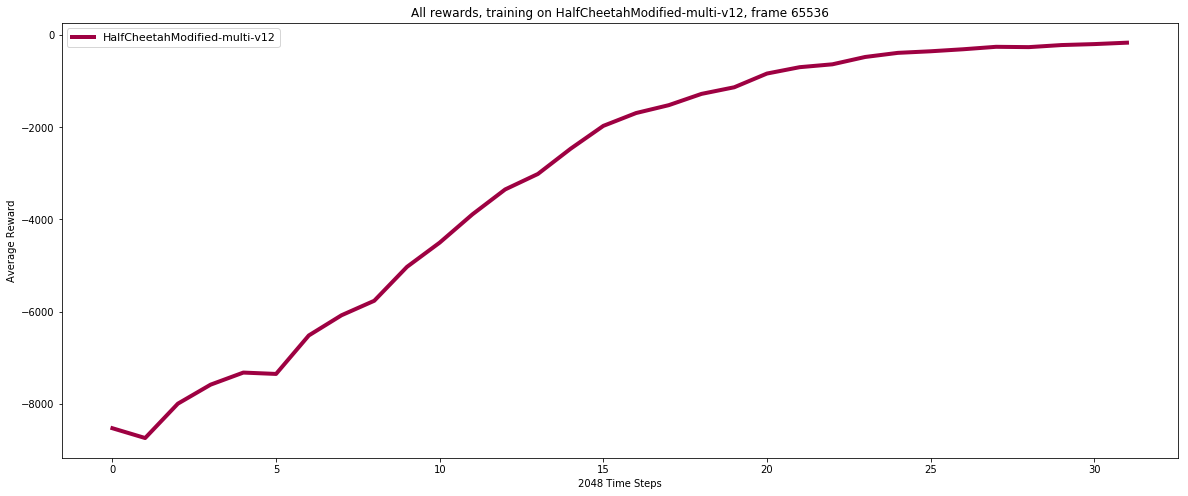

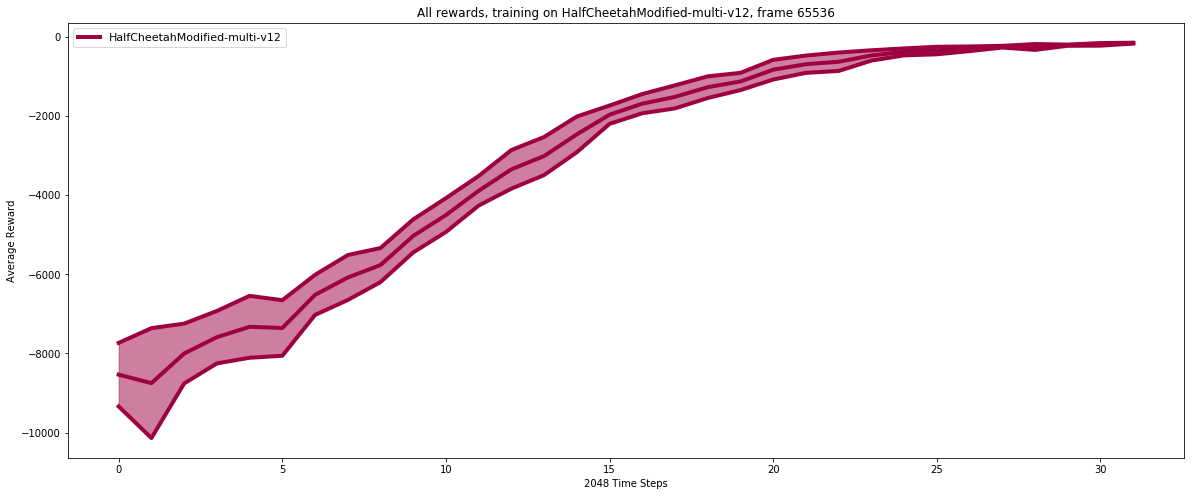

In [ ]:
state = envs.reset()
early_stop = False
ppo_updates = 0
save_interval = 5
#Plotting Flags
indvplots=0
rewplots=1
stdplots=1
which_plts = [indvplots,rewplots,stdplots]

while compensator_weighting.frame_idx < max_frames and not early_stop:

    #collect data
    log_probs, values, states, actions, rewards, masks, next_value = compensator_weighting.collect_data(envs)
    
    #compute gae
    returns = compensator_weighting.compute_gae(next_value, rewards, masks, values)
    
    #update policy
    compensator_weighting.ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, values)
    
    #plot
    avg_rew = []
    std = []
    
    #Environment testing and data logging
    #***************************************************************************************
    for env in tests.envs:
        env_rewards = ([tests.test_env(env, comp_ensemble, compensator_weighting, action_append=ACTION_APPEND) for _ in range(test_itrs)])
        avg_rew.append(np.mean(env_rewards))
        std.append(np.std(env_rewards))

    test_avg_rewards.append(avg_rew)
    test_stds.append(std)

    if avg_rew[test_env_idx] > threshold_reward and EARLY_STOPPING: #avg_rew[0] is testing on the non edited environment
        tests.plot(compensator_weighting.frame_idx, test_avg_rewards, test_stds, which_plts, num_steps, 1)
        early_stop = True
    else:
        if ppo_updates and ppo_updates % save_interval == 0:
            compensator_weighting.save_weights(comp_dir + env_name + '_weights' + str(ppo_updates/save_interval))
            tests.plot(compensator_weighting.frame_idx, test_avg_rewards, test_stds, which_plts, num_steps, 1, str(ppo_updates/save_interval))
        else:
            tests.plot(compensator_weighting.frame_idx, test_avg_rewards, test_stds, which_plts, num_steps, 0)
            
    ppo_updates = ppo_updates + 1 #Loop counter
    #***************************************************************************************

compensator_weighting.save_weights(comp_dir + env_name + '_endweights')

trained_compensator_mixer_weights_dir = comp_dir + env_name + '_endweights'
print(comp_dir + env_name + '_endweights')

In [10]:
print(len(actions))

actions_tensor = torch.cat(actions, dim=0)
avg_tensor = torch.mean(actions_tensor, dim=0)

print(actions_tensor.size())
print(avg_tensor)

NameError: name 'actions' is not defined

# Test on multi2

In [ ]:
#Hyper params:
hidden_size      = 32
lr               = 3e-5
num_steps        = 2048
mini_batch_size  = 64
ppo_epochs       = 10
threshold_reward = 1100

compensator_weighting = PPO_Ensemble(num_inputs, num_outputs, comp_ensemble, hidden_size=hidden_size, num_steps=num_steps, lr=lr)
print(compensator_weighting.model)

compensator_weighting.load_weights(trained_compensator_mixer_weights_dir)
env_name = 'InvertedPendulumModified-multi2-v10'

#Training envs (all the same)
envs = [make_env(env_name) for i in range(num_envs)]
envs = SubprocVecEnv(envs)

max_frames = 1000000
frame_idx  = 0
test_avg_rewards = []
test_stds = []
test_itrs = 20

state = envs.reset()
early_stop = False
ppo_updates = 0
save_interval = 5
#Plotting Flags
indvplots=0
rewplots=1
stdplots=1
which_plts = [indvplots,rewplots,stdplots]

while compensator_weighting.frame_idx < max_frames and not early_stop:

    #collect data
    log_probs, values, states, actions, rewards, masks, next_value = compensator_weighting.collect_data(envs)
    
    #compute gae
    returns = compensator_weighting.compute_gae(next_value, rewards, masks, values)
    
    #update policy
#     compensator_weighting.ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, values)
    
    #plot
    avg_rew = []
    std = []
    
    #Environment testing and data logging
    #***************************************************************************************
    for env in tests.envs:
        env_rewards = ([tests.test_env(env, comp_ensemble, compensator_weighting, action_append=ACTION_APPEND) for _ in range(test_itrs)])
        avg_rew.append(np.mean(env_rewards))
        std.append(np.std(env_rewards))

    test_avg_rewards.append(avg_rew)
    test_stds.append(std)

    if avg_rew[test_env_idx] > threshold_reward and EARLY_STOPPING: #avg_rew[0] is testing on the non edited environment
        tests.plot(compensator_weighting.frame_idx, test_avg_rewards, test_stds, which_plts, num_steps, 1)
        early_stop = True
    else:
        if ppo_updates and ppo_updates % save_interval == 0:
            compensator_weighting.save_weights(comp_dir + env_name + '_weights' + str(ppo_updates/save_interval))
            tests.plot(compensator_weighting.frame_idx, test_avg_rewards, test_stds, which_plts, num_steps, 1, str(ppo_updates/save_interval))
        else:
            tests.plot(compensator_weighting.frame_idx, test_avg_rewards, test_stds, which_plts, num_steps, 0)
            
    ppo_updates = ppo_updates + 1 #Loop counter
    #***************************************************************************************

compensator_weighting.save_weights(comp_dir + env_name + '_endweights')